In [1]:
import math,csv, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf
import scipy.integrate as integrate
import pylab as P
from scipy.optimize import minimize
from collections import Counter
from numpy import linalg as LA
from scipy.stats import norm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
mu_array = np.arange(1,10,1)
q = 0.25

In [6]:
def generate_data(n,n0,mu):
    null_pvals      = np.random.uniform(size=n0) # Null p values
    all_vals        = np.zeros(n)
    alternate_obs   = np.random.normal(mu,1, size = n-n0)
    all_vals[n0:n]= alternate_obs
    alternate_pvals = 1 - norm.cdf(alternate_obs, 0, 1)
    all_pvals       = np.append(null_pvals, alternate_pvals)
    return all_pvals, null_pvals, alternate_pvals, all_vals
    
def Bh_q(pvals, q):
    n                      = pvals.shape[0]
    sort_order             = np.argsort(pvals)
    reverse_sort_order     = np.argsort(sort_order)
    p_vals_sorted          = pvals[sort_order]
    p_vals_sorted_adjusted = n*p_vals_sorted/(np.arange(1,n+1)*q)
    Rejected = np.array([False]*n)
    Rejected[np.where(p_vals_sorted_adjusted<1)] = True
    
    return Rejected[reverse_sort_order], p_vals_sorted_adjusted[reverse_sort_order]

def W_Bhq(x):
    return np.ones_like(x)

def W_1(x):
    return 1 - x


def W_2_5(x):
    return np.maximum(1 - 2.5*x,0.5)

def W_5(x):
    return np.maximum(1 - 5*x,0.5)

def W_10(x):
    return np.maximum(1 - 10*x,0.5)

def W_quad_1(x):
    return np.maximum(-5*x*x+2.5*x+0.6,0)

def W_quad_2(x):
    x = x - 0.1
    return np.maximum(-5*x*x+2.5*x+0.6,0)

def W_exp(x):
    return np.exp(-x)

def Bh_q_random(pvals, q, W):
    n                  = pvals.shape[0]
    sort_order         = np.argsort(pvals)
    p_vals_sorted      = pvals[sort_order]
    sampling_int       = np.array( np.random.random(size=n) < W(p_vals_sorted), dtype='int')
    for i in np.arange(n-1,-1,-1):
        LHS, _ = integrate.quad(lambda x: W(x), 0, p_vals_sorted[i])
        RHS    = np.sum(sampling_int[:i])*float(q)/float(n)
        if LHS < RHS:
            break

    Rejected     = np.array([False]*n)
    Rejected[:i] = True
    Rejected[np.where(sampling_int==0)] = False

    reverse_sort_order = np.argsort(sort_order)
    return Rejected[reverse_sort_order], p_vals_sorted[i], sampling_int,i

def random_Bh_q(pvals, q, W):
    n                  = pvals.shape[0]
    sort_order         = np.argsort(pvals)
    p_vals_sorted      = pvals[sort_order]
    sampling_int       = np.array( np.random.random(size=n) < W(p_vals_sorted), dtype='int')
    sampled_positions  = np.where(sampling_int==1)
    sampled_p_values   = p_vals_sorted[sampled_positions]
    Rejected_temp, _   = Bh_q(sampled_p_values, q)

    Rejected     = np.array([False]*n)
    Rejected[sampled_positions] = Rejected_temp
    reverse_sort_order = np.argsort(sort_order)
    try:
        i = np.where(Rejected==True)[0][-1]
    except:
        i = 0
    return Rejected[reverse_sort_order], p_vals_sorted[i], sampling_int,i

def plot_ratio(F1, F2, name):
    global mu_array
    plt.figure(figsize=(5,5))
    plt.plot(mu_array, F1/F2)
    plt.title("ratio of powers of fdr_with_random/random_then_fdr for function " + name)
    plt.xlabel("mu")
    plt.ylabel("ratio")
    plt.show()

In [112]:
def run_experiment(n=200, n0=150, no_exp=30, method = Bh_q_random, q=0.25, W=W_Bhq, name="Bhq", plot=False): 
    global mu_array
    FDR_array     = np.zeros_like(mu_array,dtype='float')
    Power_array   = np.zeros_like(mu_array,dtype='float')
    Stopped_array = np.zeros_like(mu_array,dtype='float')
    Bias_array    = np.zeros_like(mu_array,dtype='float')
    null_p_array      = np.array([])
    alternate_p_array = np.array([])
    for i, mu in enumerate(mu_array):
        for j in range(no_exp):
            all_p, null_p, alternate_p, all_vals    = generate_data(n,n0,mu)
            a, stopping_pvalue, sampling_int, istar = method(all_p, q, W)
            Rejections        = np.where(a==True)[0] #Positions of rejections
            if len(Rejections) == 0:
                continue
            FDP               = float(len(np.where(Rejections<n0)[0]))/max(len(Rejections),1)
            # Bias
            Estimated_values  = all_vals[Rejections]
            Bias_array[i]    += np.mean(np.abs(Estimated_values-mu))
            #FDR
            FDR_array[i]     += FDP
            #Power
            Power_array[i] += float(len(Rejections))/(n-n0)*(1-FDP)
            Stopped_array[i] += stopping_pvalue
            
            #Binning values
            null_p_array         = np.append(null_p_array,null_p)
            alternate_p_array    = np.append(alternate_p_array,alternate_p)

    FDR_array     = FDR_array/no_exp
    Power_array   = Power_array/no_exp
    Stopped_array = Stopped_array/no_exp
    Bias_array    = Bias_array/no_exp
    if plot:
        plt.figure(figsize=(16,8))
        plt.subplot(321)
        plt.plot(mu_array,FDR_array, label="Emprical FDR with "+name)
        plt.ylim(0,q*1.3)
        plt.axhline(q, color = 'red', label="FDR threshold q")
        plt.legend()
        plt.ylabel("FDR")
        plt.xlabel("mu")

        plt.subplot(322)
        plt.plot(mu_array,Power_array, label="Emprical Power for "+name)
        plt.legend()
        plt.ylim(0,1)
        plt.ylabel("Power")
        plt.xlabel("mu")

        plt.subplot(323)
        plt.plot(mu_array,Stopped_array, label="Stoppage time for  "+name)
        plt.ylim(0,1.1)
        plt.legend()
        plt.ylabel("Stoppage p value")
        plt.xlabel("mu")

        plt.subplot(324)
        x = np.arange(0,1,0.1)
        plt.xlabel("p _value")
        plt.ylabel("rejection probability")
        plt.ylim(0,1.1)
        plt.title("rejection curve W(x)")
        plt.axvline(np.mean(Stopped_array),color="red")
        plt.plot(x,W(x))

        plt.subplot(325)
        plt.plot(mu_array,Bias_array, label="Bias for "+name)
        plt.xlabel("mu")
        plt.ylabel("absolute bias")
        plt.title("Bias")
        
        
        plt.subplot(326)
        plt.hist(null_p_array, color="black", label="null values", bins = 50,normed=True)
        plt.hist(alternate_p_array, color="blue", label="alternate values", bins = 50, normed=True)
        plt.xlabel("x")
        plt.ylabel("p(x)")
        plt.title("data")
        plt.legend()
        
        
        plt.show()
    return FDR_array, Power_array, Stopped_array, Bias_array

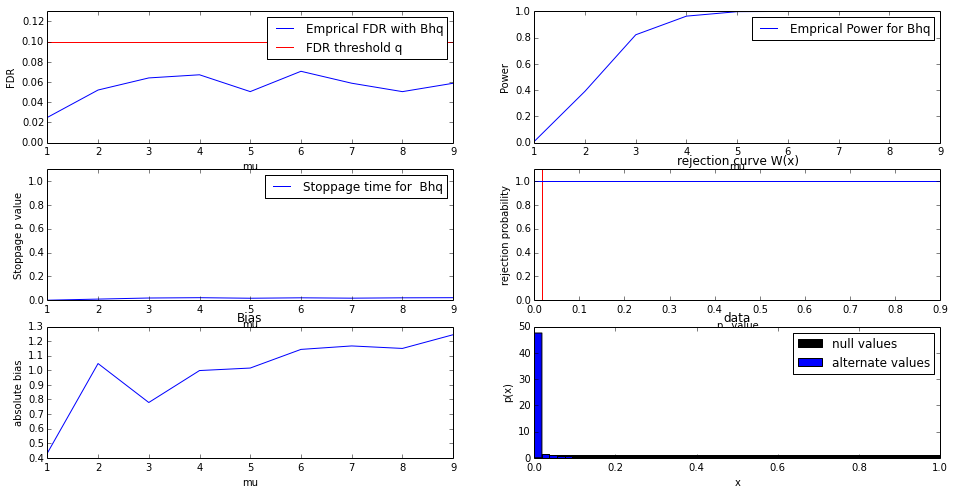

In [113]:
FDR_array_Bhq, Power_array_Bhq, Stopped_array_Bhq, Bias_array_Bhq = run_experiment(n=200, n0=150, no_exp=10,
                                                                   q=q, W=W_Bhq, name="Bhq", plot=True)

# FDR_array_Bhq_Easy, Power_array_Bhq_Easy, Stopped_array_Bhq_Easy = run_experiment(n=200, n0=150, no_exp=100, 
#                                                             method= random_Bh_q, q=q, W=W_Bhq, name="Bhq", plot=True)
# plot_ratio(Power_array_Bhq, Power_array_Bhq_Easy, "Bhq")

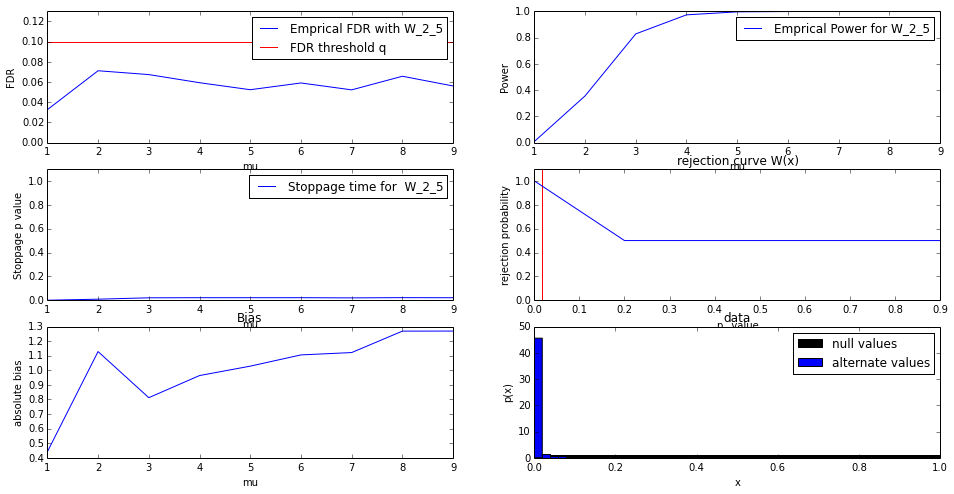

In [114]:
FDR_array_W_2_5, Power_array_W_2_5, Stopped_array_W_2_5, Bias_array_W_2_5 = run_experiment(n=200, n0=150, no_exp=100,
                                                                   q=q, W=W_2_5, name = "W_2_5", plot = True)

# FDR_array_W_2_5_Easy, Power_array_W_2_5_Easy, Stopped_array_W_2_5_Easy = run_experiment(n=100, n0=70, no_exp=100,
#                                                     method= random_Bh_q, q=q, W=W_2_5, name = "W_2_5", plot = True)

# plot_ratio(Power_array_W_2_5, Power_array_W_2_5_Easy, "W_2_5")

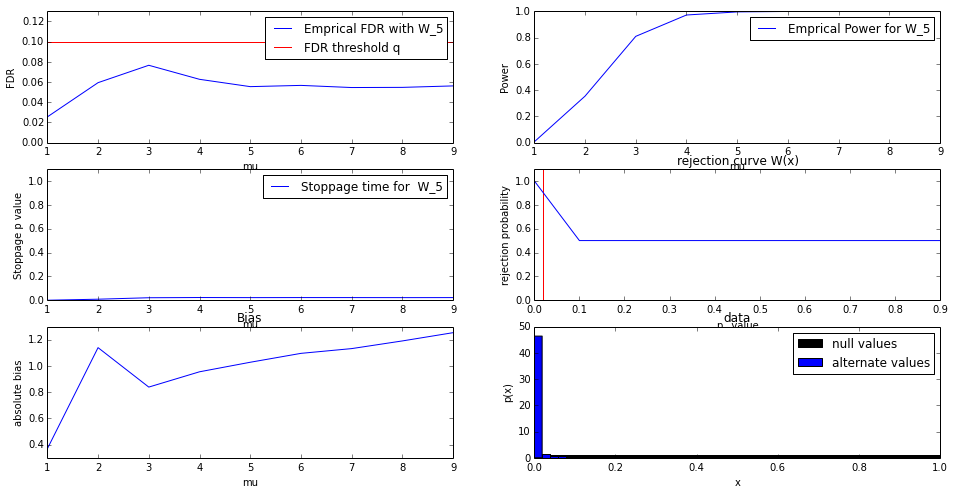

In [115]:
FDR_array_W_5, Power_array_W_5, Stopped_array_W_5, Bias_array_W_5 = run_experiment(n=200, n0=150, no_exp=100,
                                                                   q=q, W=W_5, name = "W_5", plot = True)


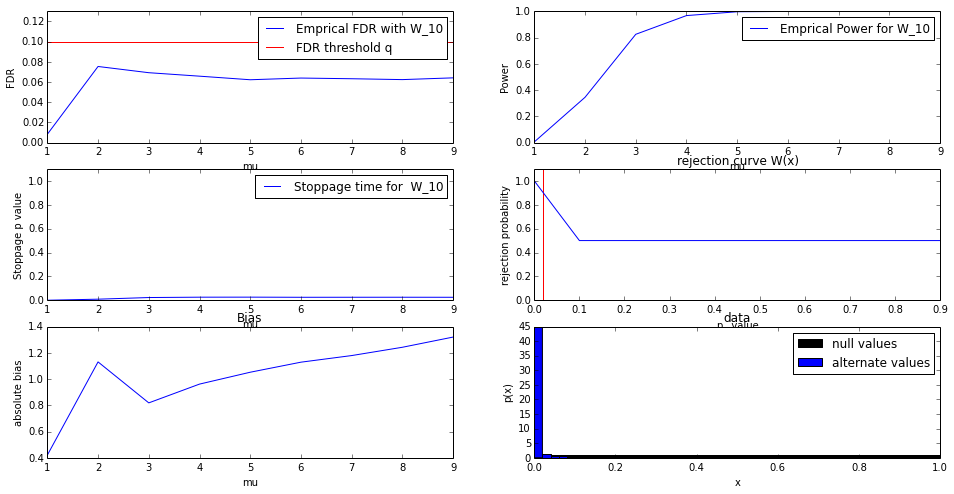

In [116]:
FDR_array_W_10, Power_array_W_10, Stopped_array_W_10, Bias_array_W_10 = run_experiment(n=200, n0=150, no_exp=100,
                                                                   q=q, W=W_10, name = "W_10", plot = True)


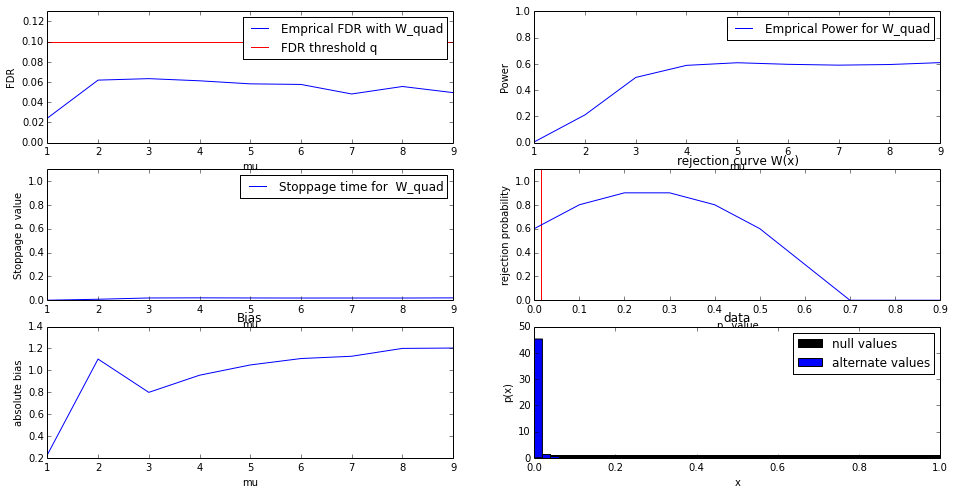

In [117]:
FDR_array_W_quad_1, Power_array_W_quad_1, Stopped_array_W_quad_1, Bias_array_W_quad_1 = run_experiment(n=200, n0=150, no_exp=100,
                                                                         q=q, W=W_quad_1, name = "W_quad", plot = True)


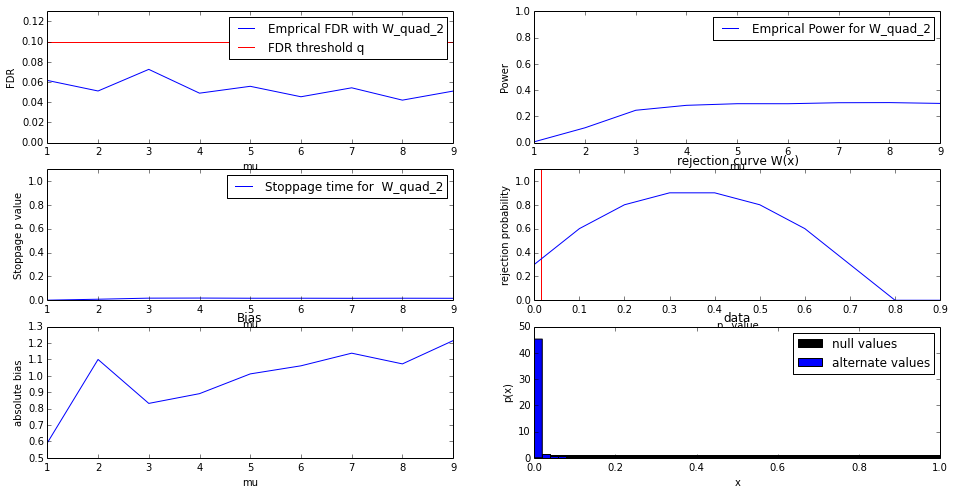

In [118]:
FDR_array_W_quad_2, Power_array_W_quad_2, Stopped_array_W_quad_2, Bias_array_W_quad_2 = run_experiment(n=200, n0=150, no_exp=100,
                                                                     q=q, W=W_quad_2, name = "W_quad_2", plot = True)


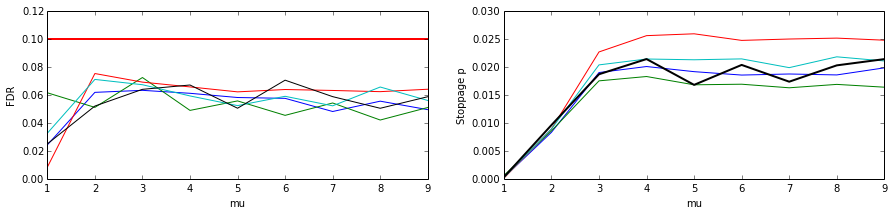

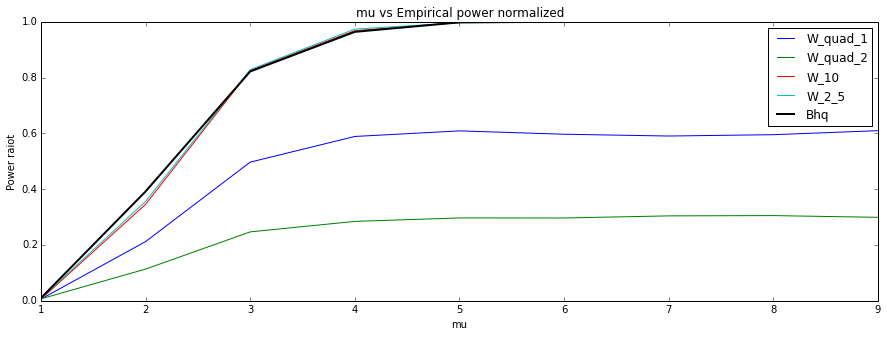

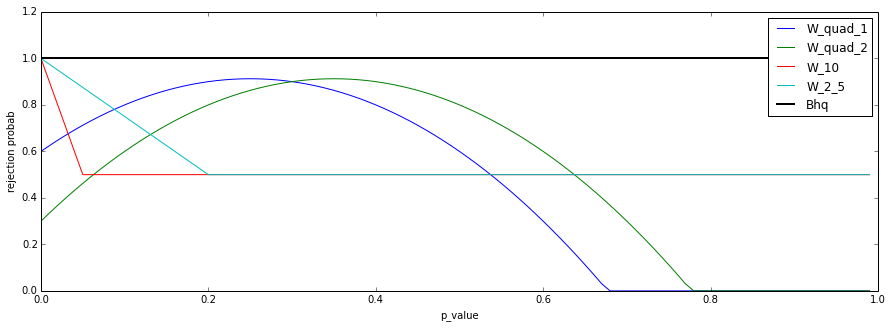

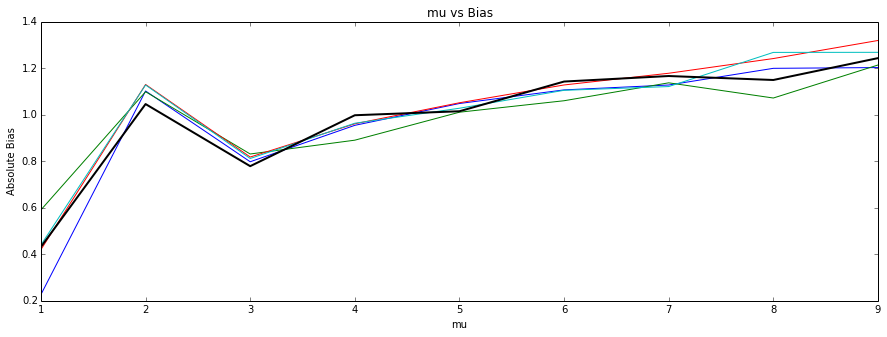

In [119]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(mu_array,FDR_array_W_quad_1, label="Emprical FDR W_quad_1")
plt.plot(mu_array,FDR_array_W_quad_2, label="Emprical FDR W_quad_2")
plt.plot(mu_array,FDR_array_W_10, label="Emprical FDR W_10")
plt.plot(mu_array,FDR_array_W_2_5, label="Emprical FDR W_2_5")
plt.plot(mu_array,FDR_array_Bhq, color="black", label="Emprical FDR Bhq")
plt.ylim(0,q*1.2)
plt.axhline(q, color = 'red',  linewidth=2, label="W_1 threshold q")
# plt.legend()
plt.ylabel("FDR")
plt.xlabel("mu")


plt.subplot(122)
plt.plot(mu_array,Stopped_array_W_quad_1, label="Emprical stoppage W_quad")
plt.plot(mu_array,Stopped_array_W_quad_2, label="Emprical stoppage W_quad_2")
plt.plot(mu_array,Stopped_array_W_10, label="Emprical stoppage W_10")
plt.plot(mu_array,Stopped_array_W_2_5, label="Emprical stoppage W_2_5")
plt.plot(mu_array,Stopped_array_Bhq, color="black",  linewidth=2, label="Emprical stoppage Bhq" )
# plt.legend()
plt.ylabel("Stoppage p")
plt.xlabel("mu")


plt.figure(figsize=(15,5))
plt.plot(mu_array,Power_array_W_quad_1, label="W_quad_1")
plt.plot(mu_array,Power_array_W_quad_2, label="W_quad_2")
plt.plot(mu_array,Power_array_W_10, label="W_10")
plt.plot(mu_array,Power_array_W_2_5, label="W_2_5")
plt.plot(mu_array,Power_array_Bhq, color="black", linewidth=2, label="Bhq" )
plt.legend()
plt.ylabel("Power raiot")
plt.title("mu vs Empirical power normalized")
plt.xlabel("mu")


x = np.arange(0,1,0.01)
plt.figure(figsize=(15,5))
plt.plot(x,W_quad_1(x), label="W_quad_1")
plt.plot(x,W_quad_2(x), label="W_quad_2")
plt.plot(x,W_10(x), label="W_10")
plt.plot(x,W_2_5(x), label="W_2_5")
plt.plot(x,W_Bhq(x), color="black",  linewidth=2, label="Bhq" )
plt.xlabel("p_value")
plt.ylabel("rejection probab")
plt.ylim(0,1.2)
plt.legend()
plt.plot()

plt.figure(figsize=(15,5))
plt.plot(mu_array, Bias_array_W_quad_1, label="W_quad_1")
plt.plot(mu_array, Bias_array_W_quad_2, label="W_quad_2")
plt.plot(mu_array, Bias_array_W_10,     label="W_10")
plt.plot(mu_array, Bias_array_W_2_5,    label="W_2_5")
plt.plot(mu_array, Bias_array_Bhq, linewidth=2,      color="black", label="Bhq" )
plt.ylabel("Absolute Bias")
plt.title("mu vs Bias")
plt.xlabel("mu")

plt.show()

1. The bias doesnt increases rapidly with $\mu$. 
2. The quad performs well when $mu$ is small.
3. Ideally the function $W(x)$ should have large mass near the $p_{true}$, where $p_{true}$ is the p_value observed for the true $\mu$

In [94]:
n = 100
n0 = 80
mu = 5
q = 0.1
W = W_Bhq
all_p, null_p, alternate_p, all_vals    = generate_data(n,n0,mu)
a, stopping_pvalue, sampling_int, istar = Bh_q_random(all_p, q, W)
Rejections        = np.where(a==True)[0] #Positions of rejections

FDP               = float(len(np.where(Rejections<n0)[0]))/max(len(Rejections),1)
# Bias
true_p_value      = 1 - norm.cdf(mu, 0, 1)
Estimated_values  = all_vals[Rejections]


0.7559270340635279

In [97]:
print all_vals[Rejections]

[ 2.96157512  5.68579696  4.36227996  6.50299389  5.8511141   6.02213684
  6.87278868  5.36042204  5.55255048  5.30039782  6.15580171  4.36300271
  4.79966871  4.51446151  5.24808871  4.77559106  5.48645774  3.86642501
  4.46006531  5.1830611 ]


In [99]:
print FDP
print np.mean(np.abs(mu - all_vals[Rejections])),np.mean(all_vals[Rejections])

0.0
0.755927034064 5.16623397338


In [120]:
1 - norm.cdf(1, 0, 1)

0.15865525393145707